In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as date
from matplotlib import rcParams
from scipy.stats import gaussian_kde
from scipy.stats import iqr
import datetime

In [22]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, Query
from sqlalchemy import create_engine, func, Table, Column, Integer, Float, ForeignKey, String, Date, update
from sqlalchemy.orm import relationship
from sqlalchemy.ext.declarative import declarative_base


In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()

In [26]:
# reflect the tables
Base.prepare(engine, reflect = True)

In [27]:
# View all of the classes in the DB
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [29]:
# Preview of the Station table
station_res = engine.execute("select * from station")
station_df = pd.read_sql_table("station", "sqlite:///Resources/hawaii.sqlite", index_col="id")
station_df.head(5).style

,station,name,latitude,longitude,elevation
id,,,,,
1,USC00519397,"WAIKIKI 717.2, HI US",21.271600,-157.816800,3.000000
2,USC00513117,"KANEOHE 838.1, HI US",21.423400,-157.801500,14.600000
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.521300,-157.837400,7.000000
4,USC00517948,"PEARL CITY, HI US",21.393400,-157.975100,11.900000
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.499200,-158.011100,306.600000


In [30]:
station_res.close()

In [31]:
# Preview of the Measurement table
measure_res = engine.execute("select * from measurement")
measure_df = pd.read_sql_table("measurement", "sqlite:///Resources/hawaii.sqlite", index_col="id")

measure_df.head(5).style

,station,date,prcp,tobs
id,,,,
1,USC00519397,2010-01-01,0.080000,65.000000
2,USC00519397,2010-01-02,0.000000,63.000000
3,USC00519397,2010-01-03,0.000000,74.000000
4,USC00519397,2010-01-04,0.000000,76.000000
5,USC00519397,2010-01-06,nan,73.000000


In [32]:
measure_res.close()

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [34]:
# Find the most recent date in the data set.
dates = session.query(Measurement.date)
dates_asc = dates.order_by(Measurement.date)
first_date = dates_asc.first().date

first_date

'2010-01-01'

#### Design a query to retrieve the last 12 months of precipitation data and plot the results. 


In [35]:
# Starting from the most recent data point in the database. 
dates_des = dates.order_by(Measurement.date.desc())
last_date = dates_des.first().date
last_date_dt = dt.datetime.strptime(last_date, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
prev_year = last_date.replace("2017", "2016")
prev_year_dt = dt.datetime.strptime(prev_year, "%Y-%m-%d")

print(last_date_dt)
print(prev_year_dt)

2017-08-23 00:00:00
2016-08-23 00:00:00


In [36]:
# Perform a query to retrieve the data and precipitation scores from the last 12 months
p_scores = session.query(Measurement.date, func.round(func.avg(Measurement.prcp),4)).\
    filter(Measurement.date >= prev_year_dt - dt.timedelta(days=1)).\
    order_by(Measurement.date).\
    group_by(Measurement.date)

print(f"{p_scores[0:4]} ... [{p_scores[-1]}]")

[('2016-08-23', 0.4517), ('2016-08-24', 1.555), ('2016-08-25', 0.0771), ('2016-08-26', 0.0167)] ... [('2017-08-23', 0.1325)]


In [37]:
# Save the query results as a Pandas DataFrame and set the index to the date column
p_df = pd.read_sql_query(p_scores.statement,engine)
p_df.set_index("date",inplace=True)
p_df.rename(columns={"round_1":"avg_prcp"},inplace=True)
# Sort the dataframe by date
p_df.sort_values("date")
p_df.head(5).style

,avg_prcp
date,
2016-08-23,0.451700
2016-08-24,1.555000
2016-08-25,0.077100
2016-08-26,0.016700
2016-08-27,0.064000


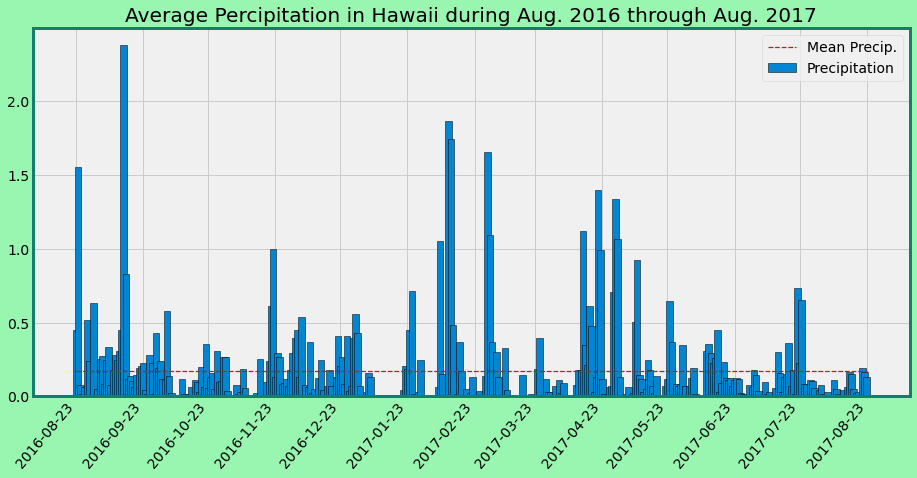

In [38]:
# Use Pandas Plotting with Matplotlib to plot the data
noidx_dt = p_df.index.values
plt_df = pd.DataFrame({'Dates': noidx_dt, 'Precipitation': p_df['avg_prcp']})
plt_df['Dates'] = pd.to_datetime(plt_df['Dates'])

months =[]
for x in plt_df['Dates']:
    if x.day == 23:
            months.append(f'{x.date()}')

ax = plt_df.plot.bar(
        x = 'Dates',y= 'Precipitation',
        title="Average Percipitation in Hawaii during Aug. 2016 through Aug. 2017",
        facecolor="xkcd:cerulean",edgecolor='k',use_index=False,
        xlim=(plt_df['Dates'].iloc[0],plt_df['Dates'].iloc[-1]),width=3,figsize=(13,13)
)
ax.set_xticks([plt_df.index.get_loc(m) for m in months])
ax.xaxis.set_ticklabels(months)
ax.spines["top"].set_color('xkcd:blue green')
ax.spines["bottom"].set_color('xkcd:blue green')
ax.spines["left"].set_color('xkcd:blue green')
ax.spines["right"].set_color('xkcd:blue green')
ax.figure.set_facecolor(color='xkcd:light sea green')
ax.figure.tight_layout()
ax.autoscale(tight=False)
plt.hlines(y=p_df.mean(),xmin =ax.get_xticks()[0] ,xmax=ax.get_xticks()[-1],linewidths=1.25,linestyles='dashed',label='Mean Precip.',colors='red')
plt.subplots_adjust(top=.5)
ax.legend()
ax.figure.set_frameon(True)
for label in ax.get_xticklabels():
        label.set_rotation(50)
        label.set_horizontalalignment('right')

In [39]:
plt.close('all')

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
p_df.describe()

,avg_prcp
count,366.000000
mean,0.170758
std,0.295685
min,0.000000
25%,0.008600
50%,0.070000
75%,0.191700
max,2.380000


# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.station)
station_num = stations.count()
print(f'{station_num} stations participated in collecting this data.')

9 stations participated in collecting this data.


In [42]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_measure = session.query(Measurement.station, Station.name,func.count(Measurement.date)).\
                group_by(Station.name).\
                order_by(func.count(Measurement.date).desc()).\
                join(Station, Station.station == Measurement.station)
station_meas = station_measure.all()

print(f'The most active station was {station_meas[0][0]}, aka {station_meas[0][1]}, with a total of {station_meas[0][2]} observations.')
print(f'The least active station was {station_meas[-1][0]}, aka {station_meas[-1][1]}, with a total of {station_meas[-1][2]} observations.')
print(f'Full Order Follows:')
for i in range(9):
        print((station_meas[i][0],station_meas[i][1],station_meas[i][2]))

The most active station was USC00519281, aka WAIHEE 837.5, HI US, with a total of 2772 observations.
The least active station was USC00518838, aka UPPER WAHIAWA 874.3, HI US, with a total of 511 observations.
Full Order Follows:
('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)


In [48]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temp = session.query(Measurement.station, func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
                group_by(Measurement.station).\
                filter(Measurement.station == station_meas[0][0])

print(f"Over the year, the most active station {station_meas[0][1]} (id {station_meas[0][0]})\nobserved a minimum temperature of {station_temp[0][1]} and a maximum temperature of {station_temp[0][3]},\nwith an average of {round(station_temp[0][2],1)}.")

Over the year, the most active station WAIHEE 837.5, HI US (id USC00519281)
observed a minimum temperature of 54.0 and a maximum temperature of 85.0,
with an average of 71.7.


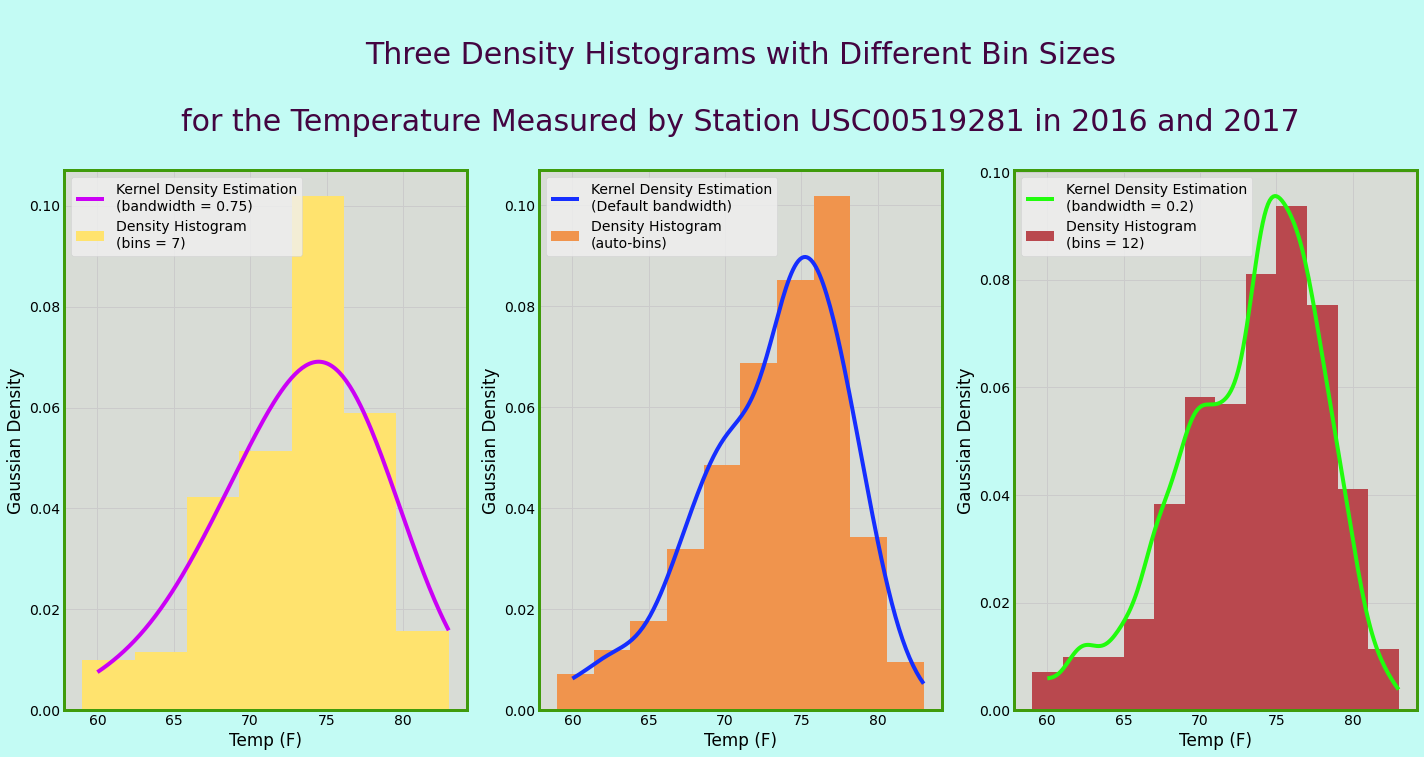

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temps = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                filter(Measurement.date >= prev_year_dt - dt.timedelta(days=1)).\
                filter_by(station= station_meas[0][0])
        
temp_df= pd.read_sql_query(year_temps.statement,engine)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
hist1 = ax1.hist(temp_df['tobs'],bins = 7,density=True, label = "Density Histogram\n(bins = 7)",color="xkcd:yellow tan")
dense1 = gaussian_kde(temp_df['tobs'],bw_method=.75)
x = np.linspace(60,83,200)
kde1 = ax1.plot(x,dense1(x),label="Kernel Density Estimation\n(bandwidth = 0.75)",color="xkcd:hot purple")

hist2 = ax2.hist(temp_df['tobs'],density=True, label = "Density Histogram\n(auto-bins)",color="xkcd:faded orange")
dense2 = gaussian_kde(temp_df['tobs'])
kde2 = ax2.plot(x,dense2(x),label="Kernel Density Estimation\n(Default bandwidth)",color="xkcd:vivid blue")

hist3 = ax3.hist(temp_df['tobs'],bins=12,density=True, label = "Density Histogram\n(bins = 12)",color="xkcd:dusty red")
dense3 = gaussian_kde(temp_df['tobs'],bw_method=0.2)
kde3 = ax3.plot(x,dense3(x),label="Kernel Density Estimation\n(bandwidth = 0.2)",color="xkcd:electric green")

ax2.set_title(f"\nThree Density Histograms with Different Bin Sizes\n\nfor the Temperature Measured by Station {station_meas[0][0]} in 2016 and 2017\n",fontsize = 30,color='xkcd:eggplant purple')

xl = "Temp (F)"
yl = "Gaussian Density"

for ax in [ax1,ax2,ax3]:
    for pos in ['top','bottom','left','right']:
        getattr(ax,'spines')[pos].set_color('xkcd:grass green')
        getattr(ax,'set_xlabel')(xl)
        getattr(ax,'set_ylabel')(yl)
        getattr(ax,'legend')(loc='upper left')
        getattr(ax,'set_facecolor')(color='xkcd:light grey')
        
ax.figure.set_facecolor(color='xkcd:duck egg blue')

plt.tight_layout()
plt.subplots_adjust(top=1.75)
plt.subplots_adjust(bottom=1)
plt.show()



In [50]:
plt.close('all')

# Close Session

In [51]:
# Close Session
session.close()